In [1]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
import seaborn as sns
import os
import matplotlib.dates as mdates

from datetime import datetime

from scipy.stats import uniform, randint
import time
import joblib
import os


import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
df = pd.read_csv('Stale Listing Algorithm Data Sheet - Sheet1.csv')
df

,Property_Address,DOM,Showings_Total,Showings_Last_7_Days,Offers,Under_Contract
0,706_Ashlawn_Pl,141,7,1,0,No
1,7109_Harding_Dr,108,29,2,1,No
2,2778_Ashwood_Rd,21,3,2,0,No
3,109_Rosswood_Dr,19,16,11,0,No
4,226_Village_Cir_W,18,1,0,0,No
5,3208_Jonesboro_Dr,133,15,2,1,No
6,3007_Gladeville_Cir,64,3,0,0,No
7,818_Williamsburg_W_Dr,64,7,1,0,No
8,8207_Sawyer_Brown_Dr_H2,51,5,1,0,No
9,1815_26th_Ave_N,55,4,0,0,No


In [3]:
df['Showings_Red_Flag'] = df['Showings_Last_7_Days'] < 3
df['Offers_Red_Flag'] = df['Offers'] < 1
df

,Property_Address,DOM,Showings_Total,Showings_Last_7_Days,Offers,Under_Contract,Showings_Red_Flag,Offers_Red_Flag
0,706_Ashlawn_Pl,141,7,1,0,No,True,True
1,7109_Harding_Dr,108,29,2,1,No,True,False
2,2778_Ashwood_Rd,21,3,2,0,No,True,True
3,109_Rosswood_Dr,19,16,11,0,No,False,True
4,226_Village_Cir_W,18,1,0,0,No,True,True
5,3208_Jonesboro_Dr,133,15,2,1,No,True,False
6,3007_Gladeville_Cir,64,3,0,0,No,True,True
7,818_Williamsburg_W_Dr,64,7,1,0,No,True,True
8,8207_Sawyer_Brown_Dr_H2,51,5,1,0,No,True,True
9,1815_26th_Ave_N,55,4,0,0,No,True,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Property_Address      11 non-null     object
 1   DOM                   11 non-null     int64 
 2   Showings_Total        11 non-null     int64 
 3   Showings_Last_7_Days  11 non-null     int64 
 4   Offers                11 non-null     int64 
 5   Under_Contract        11 non-null     object
 6   Showings_Red_Flag     11 non-null     bool  
 7   Offers_Red_Flag       11 non-null     bool  
dtypes: bool(2), int64(4), object(2)
memory usage: 682.0+ bytes


In [5]:
df.describe()

,DOM,Showings_Total,Showings_Last_7_Days,Offers
count,11.000000,11.000000,11.000000,11.000000
mean,63.363636,8.363636,1.909091,0.272727
std,45.323885,8.453079,3.113023,0.467099
min,18.000000,1.000000,0.000000,0.000000
25%,22.000000,3.000000,0.500000,0.000000
50%,55.000000,5.000000,1.000000,0.000000
75%,86.000000,11.000000,2.000000,0.500000
max,141.000000,29.000000,11.000000,1.000000


In [6]:
Red_Flags = df[(df['Showings_Red_Flag'] == True) | (df['Offers_Red_Flag'] == True)]
Red_Flags

,Property_Address,DOM,Showings_Total,Showings_Last_7_Days,Offers,Under_Contract,Showings_Red_Flag,Offers_Red_Flag
0,706_Ashlawn_Pl,141,7,1,0,No,True,True
1,7109_Harding_Dr,108,29,2,1,No,True,False
2,2778_Ashwood_Rd,21,3,2,0,No,True,True
3,109_Rosswood_Dr,19,16,11,0,No,False,True
4,226_Village_Cir_W,18,1,0,0,No,True,True
5,3208_Jonesboro_Dr,133,15,2,1,No,True,False
6,3007_Gladeville_Cir,64,3,0,0,No,True,True
7,818_Williamsburg_W_Dr,64,7,1,0,No,True,True
8,8207_Sawyer_Brown_Dr_H2,51,5,1,0,No,True,True
9,1815_26th_Ave_N,55,4,0,0,No,True,True


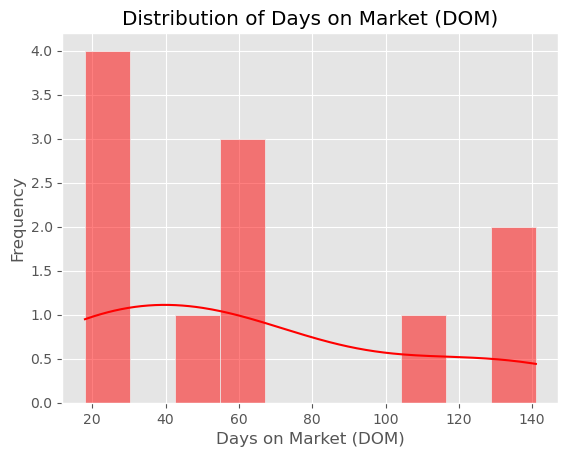

In [7]:
sns.histplot(Red_Flags['DOM'], kde=True, bins=10, color='red')
plt.title('Distribution of Days on Market (DOM)')
plt.xlabel('Days on Market (DOM)')
plt.ylabel('Frequency')
plt.show()

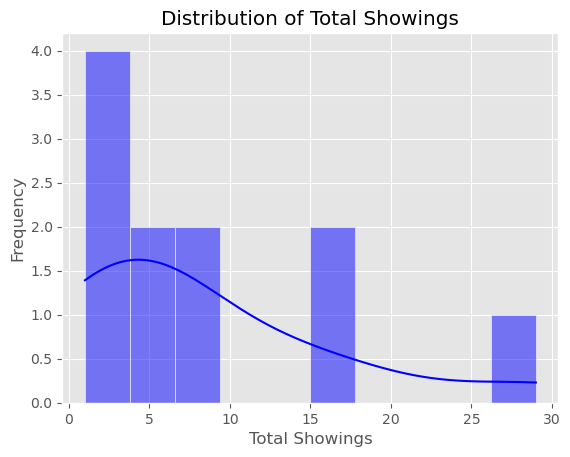

In [8]:
sns.histplot(Red_Flags['Showings_Total'], kde=True, bins=10, color='blue')
plt.title('Distribution of Total Showings')
plt.xlabel('Total Showings')
plt.ylabel('Frequency')
plt.show()

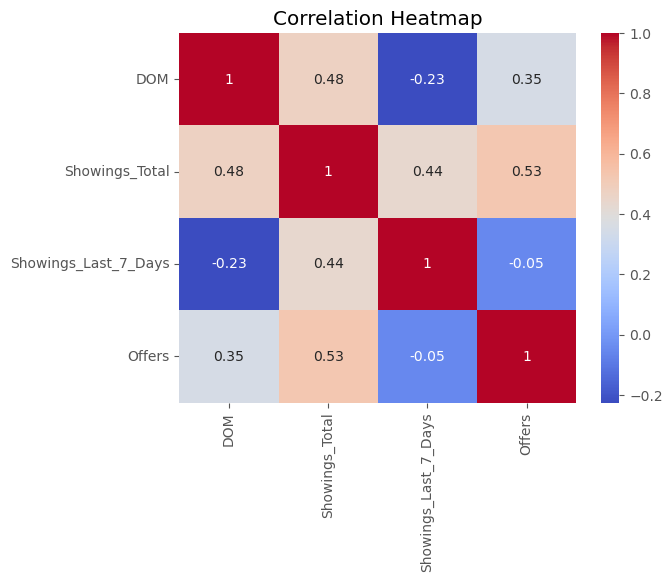

In [9]:
numeric_cols = ['DOM', 'Showings_Total', 'Showings_Last_7_Days', 'Offers']
correlation_matrix = Red_Flags[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()